# VQE for solving the ground state of a HF molecule

In this notebook we will present a brief example of how we can obtain the ground state of an HF (hydrogen fluoride) molecule by applying VQE. Content:

* Ground state energy calculation of the HF molecule with VQE  
* VQE for a circuit based on the HF molecule
* Extra: Comparison between running VQE with and without defined _active space_ 


## Ground state energy calculation

In [1]:
###### Import Libraries
import numpy as np

from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

import time

### 1.  Defining the HF molecule

In [2]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["F", [0.0, 0.0, 0.9554]]], charge=0, multiplicity=1
)

print(molecule.geometry)

[['H', [0.0, 0.0, 0.0]], ['F', [0.0, 0.0, 0.9554]]]


### 2. Driver

Drivers do the interface to the classical chemistry codes in Qiskit. By running a driver (Hartree-Fock calculation given a molecular geometry and a basis set), in the cell below, we obtain information about the molecule. For example, we can get

* number of spin orbitals
* number of particles

In [3]:
###### Define the electronic structure driver

driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF,
)

# define the electronic structure problem as a function of the driver
es_problem = ElectronicStructureProblem(driver) 

# build the second quantized Hamiltonian of the molecule
second_q_op = es_problem.second_q_ops()


# print the Hamiltonian, no. of spin orbitals or qubits, and the no. of paticles
print('\n',"The second quantized form of the electronic Hamiltonian is" , second_q_op[0])
print('\n',"The no. of spin orbitals is", es_problem.num_spin_orbitals) 
print('\n', "The total no. of electrons is", es_problem.num_particles)


 The second quantized form of the electronic Hamiltonian is Fermionic Operator
register length=12, number terms=1860
  -40.56071130048077 * ( +_0 -_0 )
+ 0.7046310162866262 * ( +_0 -_1 )
+ 0.2102365245431138 * ( +_0 -_2 )
+ -0.2199229105115464 * ( +_0 -_5 )
+ 0.7046310162866276 * ( +_1 -_0 )
+ -9.145830928600331 ...

 The no. of spin orbitals is 12

 The total no. of electrons is (5, 5)


### 3. Map the HF Hamiltonian to Qubits

`QubitConverter` allows us to converter from Second-Quantized to Qubit Operators: https://qiskit.org/documentation/nature/stubs/qiskit_nature.converters.second_quantization.QubitConverter.html

That means we can enconde the HF molecule into a circuit

In [4]:
qubit_converter = QubitConverter(JordanWignerMapper())

### 4. Calculation using NumPy - Classical Approach

We can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE. Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals. Thus, for very large systems you would run out of memory trying to store their wavefunctions.

In [5]:
%%time
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

##############################
# Provide your code here

numpy_solver = NumPyMinimumEigensolver()
numpy_ground_state_solver = GroundStateEigensolver(qubit_converter=qubit_converter, solver=numpy_solver)
numpy_results = numpy_ground_state_solver.solve(problem=es_problem)

##############################

exact_energy = np.real(numpy_results.electronic_energies + numpy_results.nuclear_repulsion_energy)[0]
print(f"Exact electronic energy: {exact_energy:.6f} Hartree\n")
print(numpy_results)

Exact electronic energy: -98.601744 Hartree

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -103.586666143228
  - computed part:      -103.586666143228
~ Nuclear repulsion energy (Hartree): 4.984922439062
> Total ground state energy (Hartree): -98.601743704166
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 10.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  16.24899905]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  16.68073854]
    - computed part:      [0.0  0.0  16.68073854]
  > Dipole moment (a.u.): [0.0  0.0  -0.43173949]  Total: 0.43173949
                 (debye): [0.0  0.0  -1.09737222]  Total: 1.09737222
 
CPU times: user 20.8 s, sys: 11.9 s, total: 32.7 s
Wall time: 8.85 s


### 5. VQE solver

The ground state energy of the molecule HF calcuated using NumPyMinimumEigensolver is -98.601743704166 Hartree. Now,calculating this ground state energy with VQE

In [6]:
%%time
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

#backend
backend=Aer.get_backend("aer_simulator_statevector")

# Select the simulator to run the calculation
quantum_instance = QuantumInstance(backend=backend)

# define the VQE simulator
vqe_solver = VQEUCCFactory(quantum_instance)

<timed exec>:11: DeprecationWarning: VQEUCCFactory Constructor: quantum_instance is no longer a positional argument as of version 0.4 and will be removed no sooner than 3 months after the release. Instead use it as a keyword argument


CPU times: user 808 ms, sys: 358 ms, total: 1.17 s
Wall time: 1.19 s


* Results

In [7]:
%%time
from qiskit_nature.algorithms import GroundStateEigensolver

# do the calculation
calc = GroundStateEigensolver(qubit_converter, vqe_solver) 

# save the result
res = calc.solve(es_problem) 

# print the result
print(res) 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -103.586665406093
  - computed part:      -103.586665406093
~ Nuclear repulsion energy (Hartree): 4.984922439062
> Total ground state energy (Hartree): -98.601742967031
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 10.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  16.24899905]
 
  0: 
  * Electronic dipole moment (a.u.): [0.00000032  -0.00000041  16.681858]
    - computed part:      [0.00000032  -0.00000041  16.681858]
  > Dipole moment (a.u.): [-0.00000032  0.00000041  -0.43285895]  Total: 0.43285895
                 (debye): [-0.0000008  0.00000104  -1.10021761]  Total: 1.10021761
 
CPU times: user 6min 18s, sys: 3min 23s, total: 9min 42s
Wall time: 2min 41s


## VQE for a circuit based on the HF molecule

This time we use `PySCFDriver`. 

In [8]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.drivers.second_quantization import PySCFDriver

driver_reduced = PySCFDriver(atom='H 0.0, 0.0, 0.0; F 0.0, 0.0,  0.9554',
                     unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='STO3G')

es_problem = ElectronicStructureProblem(driver_reduced) 

properties = driver_reduced.run()

### 1. Initial state and Ansatz

A good initial state in chemistry is the HartreeFock state, which can be incorporated to an Ansatz (in this case, a quantum circuit) that we choose to approximate our ground state

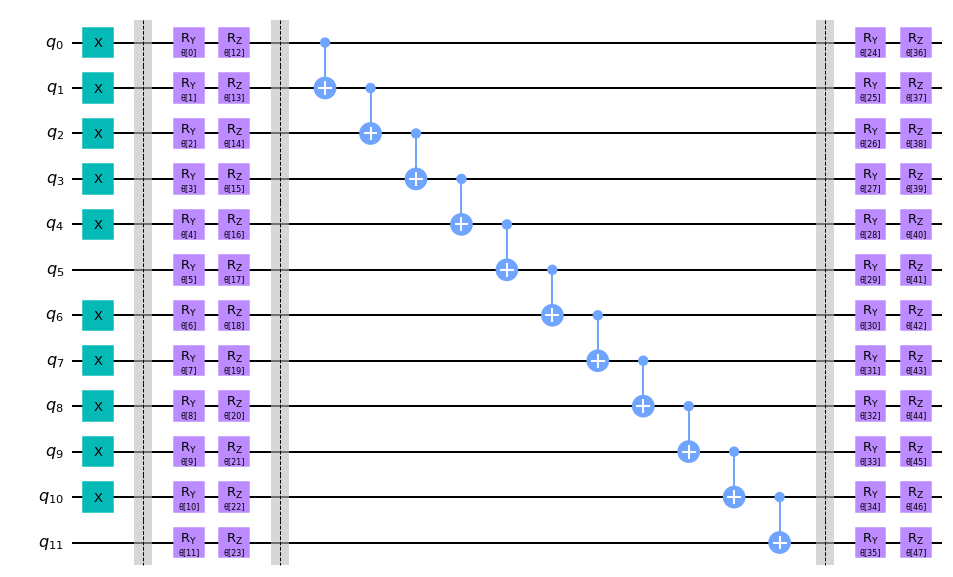

In [9]:
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber


particle_number = properties.get_property(ParticleNumber)
init_state = HartreeFock(num_spin_orbitals=particle_number.num_spin_orbitals, 
                         num_particles=particle_number.num_particles,
                         qubit_converter=qubit_converter)

init_state.barrier()

##############################

ansatz = EfficientSU2(num_qubits=particle_number.num_spin_orbitals,
                      reps=1,
                      entanglement='linear',
                      initial_state=init_state,
                      insert_barriers=True)

##############################

ansatz.decompose().draw('mpl')

Let us run it then!!

In [10]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit.algorithms.optimizers import  L_BFGS_B
from qiskit.algorithms import VQE

##############################
# Provide your code here

backend1 = StatevectorSimulator()
optimizer = L_BFGS_B(maxfun=400)

##############################

from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from jupyterplot import ProgressPlot

error_threshold = 10 # mHartree

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [11]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit.algorithms.optimizers import  L_BFGS_B
from qiskit.algorithms import VQE

##############################
# Provide your code here

backend1 = StatevectorSimulator()
optimizer = L_BFGS_B(maxfun=400)

##############################

from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from jupyterplot import ProgressPlot

error_threshold = 10 # mHartree

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [12]:
%%time
# for live plotting
pp = ProgressPlot(plot_names=['Energy'],
                  line_names=['Runtime VQE', f'Target + {error_threshold}mH', 'Target']) 

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    pp.update([[energy, exact_energy+error_threshold/1000, exact_energy]])

##############################
# Provide your code here

vqe = VQE(ansatz=ansatz,
          optimizer=optimizer,
          quantum_instance=backend1,
          callback=callback,
          initial_point=initial_point)

vqe_ground_state_solver = GroundStateEigensolver(qubit_converter=qubit_converter, solver=vqe)

vqe_results = vqe_ground_state_solver.solve(problem=es_problem)

##############################

print(vqe_results)

<IPython.core.display.Javascript object>

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -98.698404336406
  - computed part:      -98.698404336406
~ Nuclear repulsion energy (Hartree): 4.984922439062
> Total ground state energy (Hartree): -93.713481897344
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.255 S: 0.790 S^2: 1.414 M: 0.017
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  16.24899905]
 
  0: 
  * Electronic dipole moment (a.u.): [-0.20999374  -0.15789496  12.54009848]
    - computed part:      [-0.20999374  -0.15789496  12.54009848]
  > Dipole moment (a.u.): [0.20999374  0.15789496  3.70890057]  Total: 3.71819468
                 (debye): [0.53375079  0.40132893  9.42708405]  Total: 9.4507073
 
CPU times: user 4min 57s, sys: 3min 8s, total: 8min 6s
Wall time: 1min 16s


In [22]:
error = (vqe_results.computed_energies[0] - exact_energy) * 1000 # mHartree
print(f'Error is: {error:.3f} Hartree')

Error is: -96.661 Hartree


## Extra: Comparison between running VQE with and without defined _active space_ 

<b> 1. experiment without active space <b> 

In [14]:
%%time

WITHOUT__ActiveSpace = ElectronicStructureProblem(driver_reduced)
second_q_ops = WITHOUT__ActiveSpace.second_q_ops()
main_op = second_q_ops[0]

# particle_number = problem.molecule_data_transformed
# num_particles = (particle_number.num_alpha, particle_numbaer.num_beta)
# num_spin_orbitals = particle_number.num_molecular_orbitals*2

molecule = driver.run()
simulation = QuantumInstance(backend=backend)

mapper = JordanWignerMapper()
qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

qubit_op = qubit_converter.convert(main_op, num_particles=2)

CPU times: user 10.5 s, sys: 656 ms, total: 11.1 s
Wall time: 2.12 s


In [15]:
%%time
shots=10

begin = time.time()

VQE = VQEUCCFactory(simulation, optimizer=COBYLA(maxiter=shots))
calculation = GroundStateEigensolver(qubit_converter, VQE)
result0 = calculation.solve(WITHOUT__ActiveSpace)

end = time.time()
print(f"Total runtime of the program is {end - begin}")

<timed exec>:5: DeprecationWarning: VQEUCCFactory Constructor: quantum_instance is no longer a positional argument as of version 0.4 and will be removed no sooner than 3 months after the release. Instead use it as a keyword argument


Total runtime of the program is 22.879807400000573
CPU times: user 33.6 s, sys: 7.57 s, total: 41.2 s
Wall time: 22.9 s


In [16]:
np.real(result0.electronic_energies + result0.nuclear_repulsion_energy)[0]

-98.57284734206756

<b>  2. experiment with active space:<b>  `ActiveSpaceTransformer`

By using the active space transformer method, we will manage to exclude non-core electronic states by restricting calculations to the singlet and triplet. That means, we can compute this energy with a small number of qubits, keeping at the same time a high-quality description of the system.

In [17]:
# from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
transformer = ActiveSpaceTransformer(2, 2, [4,5]) 

In [18]:
%%time

WITH_ActiveSpace = ElectronicStructureProblem(driver_reduced, transformers=[transformer])
second_q_ops = WITH_ActiveSpace.second_q_ops()
main_op = second_q_ops[0]

# particle_number = problem.molecule_data_transformed
# num_particles = (particle_number.num_alpha, particle_number.num_beta)
# num_spin_orbitals = particle_number.num_molecular_orbitals*2

molecule = driver.run()
simulation = QuantumInstance(backend=backend)

mapper = JordanWignerMapper()
qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

qubit_op = qubit_converter.convert(main_op, num_particles=2)

CPU times: user 20.4 s, sys: 914 ms, total: 21.3 s
Wall time: 3.01 s


In [19]:
shots=10

simulation = QuantumInstance(backend=backend)

begin = time.time()

VQE = VQEUCCFactory(simulation, optimizer=COBYLA(maxiter=shots))
calculation = GroundStateEigensolver(qubit_converter, VQE)
result1 = calculation.solve(WITH_ActiveSpace)

end = time.time()
print(f"Total runtime of the program is {end - begin}")

<ipython-input-19-bbe03ad36781>:7: DeprecationWarning: VQEUCCFactory Constructor: quantum_instance is no longer a positional argument as of version 0.4 and will be removed no sooner than 3 months after the release. Instead use it as a keyword argument
  VQE = VQEUCCFactory(simulation, optimizer=COBYLA(maxiter=shots))


Total runtime of the program is 1.8768858000039472


In [20]:
np.real(result1.electronic_energies + result1.nuclear_repulsion_energy)[0]

-98.57284734206868

<b> Much much faster indeed!! <b>